In [6]:
import pandas as pd
from dataprep import full_preproccessing
import matplotlib.pyplot as plt

## Matrices

In [244]:
data = pd.read_csv('Food_com.csv')
data.rename(columns={'user_id': 'userid', 'recipe_id': 'movieid', "date": "timestamp"}, inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['rating'] = data['rating'] + 1
# %%
training, testset_valid, holdout_valid, testset, holdout, data_description, data_index = full_preproccessing(data)

There are 25076 users
Filtered 24583 invalid observations.


In [245]:
from sa_hooi import sa_hooi, form_attention_matrix, get_scaling_weights

In [248]:
def tf_model_build(config, data, data_description, attention_matrix=np.array([])):
    userid = data_description["users"]
    itemid = data_description["items"]
    feedback = data_description["feedback"]

    idx = data[[userid, itemid, feedback]].values
    idx[:, -1] = idx[:, -1] - data_description['min_rating'] # works only for integer ratings!
    val = np.ones(idx.shape[0], dtype='f8')

    n_users = data_description["n_users"]
    n_items = data_description["n_items"]
    n_ratings = data_description["n_ratings"]
    shape = (n_users, n_items, n_ratings)
    core_shape = config['mlrank']
    num_iters = config["num_iters"]

    if (attention_matrix.shape[0] == 0):
        attention_matrix = form_attention_matrix(
            data_description['n_ratings'],
            **config['params'],
            format = 'csr'
        ).A
        
    print(attention_matrix)

    item_popularity = (
        pd.Series(np.ones((n_items,)))
        .reindex(range(n_items))
        .fillna(1)
        .values
    )
    scaling_weights = get_scaling_weights(item_popularity, scaling=config["scaling"])


    u0, u1, u2 = sa_hooi(
        idx, val, shape, config["mlrank"],
        attention_matrix = attention_matrix,
        scaling_weights = scaling_weights,
        max_iters = config["num_iters"],
        parallel_ttm = False,
        randomized = config["randomized"],
        growth_tol = config["growth_tol"],
        seed = config["seed"],
        iter_callback = None,
    )

    return u0, u1, u2, attention_matrix

# %%
config = {
    "scaling": 1,
    "mlrank": (30, 30, 5),
    "n_ratings": data_description['n_ratings'],
    "num_iters": 4,
    "params": None,
    "randomized": True,
    "growth_tol": 1e-4,
    "seed": 42
}

# %%
def tf_scoring(params, data, data_description):
    user_factors, item_factors, feedback_factors, attention_matrix = params
    userid = data_description["users"]
    itemid = data_description["items"]
    feedback = data_description["feedback"]

    data = data.sort_values(userid)
    useridx = data[userid]
    itemidx = data[itemid].values
    ratings = data[feedback].values
    ratings = ratings - data_description['min_rating']

    n_users = useridx.nunique()
    n_items = data_description['n_items']
    n_ratings = data_description['n_ratings']

    #inv_attention = np.linalg.inv(attention_matrix.A) # change
    inv_attention = solve_triangular(attention_matrix, np.eye(5), lower=True)
    #np.testing.assert_almost_equal(inv_attention, inv_attention_)

    tensor_outer = tensor_outer_at('cpu')

    inv_aT_feedback = (inv_attention.T @ feedback_factors)[-1, :]

    scores = tensor_outer(
        1.0,
        item_factors,
        attention_matrix @ feedback_factors,
        itemidx,
        ratings
    )
    scores = np.add.reduceat(scores, np.r_[0, np.where(np.diff(useridx))[0]+1]) # sort by users
    scores = np.tensordot(
        scores,
        inv_aT_feedback,
        axes=(2, 0)
    ).dot(item_factors.T)

    return scores

In [249]:
config["params"] = {'decay_factor': 1, 'exponential_decay': False, 'reverse': False}

config['mlrank'] = (10, 10, 1)
# tf_params = tf_model_build(config, training, data_description, attention_matrix=np.array([]))
a = np.array([[1.,         0.,         0.,         0.,         0.,         0.,        ],
 [0.5,        1.    ,     0. ,        0.    ,     0. ,        0.,        ],
 [0.33333333, 0.5,        1. ,        0.    ,     0.  ,       0. ,       ],
 [0.25  ,     0.33333333 ,0.5    ,    1.   ,      0.  ,       0.  ,      ],
 [0.2   ,     0.25    ,   0.33333333, 0.5 ,       1.  ,       0.  ,      ],
 [0.16666667, 0.2   ,     0.25   ,    0.33333333, 0.5   ,     1.        ]])
print(pd.DataFrame(a @ a.T).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &         0 &         1 &         2 &         3 &         4 &         5 \\
\midrule
0 &  1.000000 &  0.500000 &  0.333333 &  0.250000 &  0.200000 &  0.166667 \\
1 &  0.500000 &  1.250000 &  0.666667 &  0.458333 &  0.350000 &  0.283333 \\
2 &  0.333333 &  0.666667 &  1.361111 &  0.750000 &  0.525000 &  0.405556 \\
3 &  0.250000 &  0.458333 &  0.750000 &  1.423611 &  0.800000 &  0.566667 \\
4 &  0.200000 &  0.350000 &  0.525000 &  0.800000 &  1.463611 &  0.833333 \\
5 &  0.166667 &  0.283333 &  0.405556 &  0.566667 &  0.833333 &  1.491389 \\
\bottomrule
\end{tabular}



C:\Users\Liza\AppData\Local\Temp\ipykernel_28904\2870607955.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(a @ a.T).to_latex())


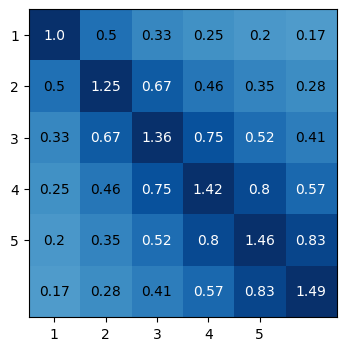

In [255]:
data = pd.DataFrame(a @ a.T)
plt.figure(figsize=(4,4))
plt.imshow(data, cmap='Blues', norm=None, vmin=-1, vmax=1)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if data.values[i, j] > 0.5:
            text = plt.text(j, i, np.round(data.values[i, j], 2),
                          ha="center", va="center", color="w")
        else:
            text = plt.text(j, i, np.round(data.values[i, j], 2),
                            ha="center", va="center", color="k")
plt.xticks(np.arange(5), labels=np.arange(1,6))
plt.yticks(np.arange(5), labels=np.arange(1,6));

In [257]:
print('Eucledian distance matrix')
eucl_matrix = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        eucl_matrix[i, j] = 1.0 / np.exp(abs(i - j)) if i != j else 1#5 + 1e-2
print(pd.DataFrame(eucl_matrix).to_latex())

Eucledian distance matrix
\begin{tabular}{lrrrrr}
\toprule
{} &         0 &         1 &         2 &         3 &         4 \\
\midrule
0 &  1.000000 &  0.367879 &  0.135335 &  0.049787 &  0.018316 \\
1 &  0.367879 &  1.000000 &  0.367879 &  0.135335 &  0.049787 \\
2 &  0.135335 &  0.367879 &  1.000000 &  0.367879 &  0.135335 \\
3 &  0.049787 &  0.135335 &  0.367879 &  1.000000 &  0.367879 \\
4 &  0.018316 &  0.049787 &  0.135335 &  0.367879 &  1.000000 \\
\bottomrule
\end{tabular}



C:\Users\Liza\AppData\Local\Temp\ipykernel_28904\3367573187.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(eucl_matrix).to_latex())


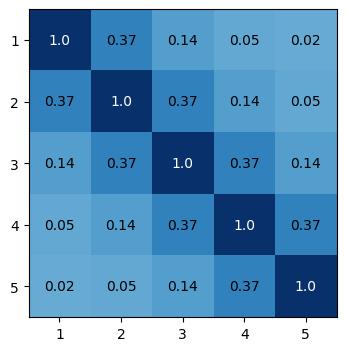

In [258]:
data = pd.DataFrame(eucl_matrix)
plt.figure(figsize=(4,4))
plt.imshow(data, cmap='Blues', norm=None, vmin=-1, vmax=1)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if data.values[i, j] > 0.5:
            text = plt.text(j, i, np.round(data.values[i, j], 2),
                          ha="center", va="center", color="w")
        else:
            text = plt.text(j, i, np.round(data.values[i, j], 2),
                            ha="center", va="center", color="k")
plt.xticks(np.arange(5), labels=np.arange(1,6))
plt.yticks(np.arange(5), labels=np.arange(1,6));

In [27]:
eucl_matrix = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        eucl_matrix[i, j] = abs(i - j) / np.exp(abs(i - j)) if i != j else 1#5 + 1e-2
print(pd.DataFrame(eucl_matrix).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &         0 &         1 &         2 &         3 &         4 \\
\midrule
0 &  1.000000 &  0.367879 &  0.270671 &  0.149361 &  0.073263 \\
1 &  0.367879 &  1.000000 &  0.367879 &  0.270671 &  0.149361 \\
2 &  0.270671 &  0.367879 &  1.000000 &  0.367879 &  0.270671 \\
3 &  0.149361 &  0.270671 &  0.367879 &  1.000000 &  0.367879 \\
4 &  0.073263 &  0.149361 &  0.270671 &  0.367879 &  1.000000 \\
\bottomrule
\end{tabular}



C:\Users\Liza\AppData\Local\Temp\ipykernel_41628\1262110274.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(eucl_matrix).to_latex())


In [27]:
rating_dist = []

total_cnt = training.shape[0]

for i in range(6):
    val = training.query(f'rating == {i + 1}').count()[0] / total_cnt

    rating_dist.append(val)

rat_dist_matrix = np.zeros((6, 6))

for i in range(6):
    for j in range(6):
        diff = abs(rating_dist[i] - rating_dist[j])
        rat_dist_matrix[i, j] = diff / np.exp(diff) if i != j else 1. + 1e-1
        
print(pd.DataFrame(rat_dist_matrix).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &         0 &         1 &         2 &         3 &         4 &         5 \\
\midrule
0 &  1.100000 &  0.011903 &  0.006648 &  0.015998 &  0.122179 &  0.355517 \\
1 &  0.011903 &  1.100000 &  0.005326 &  0.027517 &  0.131058 &  0.356822 \\
2 &  0.006648 &  0.005326 &  1.100000 &  0.022432 &  0.127140 &  0.356253 \\
3 &  0.015998 &  0.027517 &  0.022432 &  1.100000 &  0.109824 &  0.353623 \\
4 &  0.122179 &  0.131058 &  0.127140 &  0.109824 &  1.100000 &  0.333563 \\
5 &  0.355517 &  0.356822 &  0.356253 &  0.353623 &  0.333563 &  1.100000 \\
\bottomrule
\end{tabular}



C:\Users\Liza\AppData\Local\Temp\ipykernel_12720\1743756817.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(rat_dist_matrix).to_latex())


In [29]:
rating_dist

[0.01684015426667166,
 0.004792750964166698,
 0.010147152431946681,
 0.033099936346276254,
 0.1574680795297113,
 0.7776519264612274]

In [32]:
def center_and_rescale_score(x, func=None):

    if func is None:
        func = np.arctan

    return func(x - 3.5)

eucl_matrix = np.zeros((6, 6))

for i in range(6):
    for j in range(6):

        k, l = center_and_rescale_score(i + 1), center_and_rescale_score(j + 1)

        diff = abs(k - l)

        eucl_matrix[i, j] = 1 / (diff + 1)
print(pd.DataFrame(eucl_matrix).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &         0 &         1 &         2 &         3 &         4 &         5 \\
\midrule
0 &  1.000000 &  0.828160 &  0.579159 &  0.376799 &  0.315151 &  0.295807 \\
1 &  0.828160 &  1.000000 &  0.658265 &  0.408757 &  0.337201 &  0.315151 \\
2 &  0.579159 &  0.658265 &  1.000000 &  0.518862 &  0.408757 &  0.376799 \\
3 &  0.376799 &  0.408757 &  0.518862 &  1.000000 &  0.658265 &  0.579159 \\
4 &  0.315151 &  0.337201 &  0.408757 &  0.658265 &  1.000000 &  0.828160 \\
5 &  0.295807 &  0.315151 &  0.376799 &  0.579159 &  0.828160 &  1.000000 \\
\bottomrule
\end{tabular}



C:\Users\Liza\AppData\Local\Temp\ipykernel_12720\1466671247.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(eucl_matrix).to_latex())


## Base tuning

In [2]:
with open('logs_video1.txt') as f:
    lines1 = f.readlines()

In [3]:
with open('logs_video2.txt') as f:
    lines2 = f.readlines()

In [4]:
with open('logs_video3.txt') as f:
    lines3 = f.readlines()

In [52]:
with open('logs_video4.txt') as f:
    lines4 = f.readlines()

In [190]:
with open('food_recvae1.txt') as f:
    lines = f.readlines()

In [5]:
lines = lines1 + lines2 + lines3

In [6]:
# video
alpha = 5
models = []
keys = []
alphas = []
topks = []
mcs = []
hrs = []
prev_model = ''
for line in lines:
    if 'Batch' in line:
        batch = line.split(':')[-1].strip()
    if 'Model' in line:
        model = line.split(':')[-1].strip()
    if 'Hidden' in line:
        for i in range(alpha-1):
            for n in [5,10,20]:
                keys.append(line.split(':')[-1].strip())
                models.append(model)
                alphas.append(i+2)
                topks.append(n)
    if 'HR' in line:
        mcs.append(float(line.split(':')[-1].strip()))
        hrs.append(float(line.split(':')[1].strip().split(', ')[0]))

In [191]:
alpha = 5
batches = []
keys = []
alphas = []
topks = []
mcs = []
hrs = []
for line in lines:
    if 'Batch' in line:
        batch = line.split(':')[-1].strip()
    if 'Hidden' in line:
        for i in range(alpha-1):
            for n in [5,10,20]:
                keys.append(line.split(':')[-1].strip())
                alphas.append(i+2)
                topks.append(n)
                batches.append(batch)
    if 'HR' in line:
        mcs.append(float(line.split(':')[-1].strip()))
        hrs.append(float(line.split(':')[1].strip().split(', ')[0]))

In [7]:
batches = np.array([[2**i] * (len([i for i in models if i == 'triangular matrix']) // 6) for i in range(4,10)] * 5).flatten()

In [8]:
# video
res = pd.DataFrame([models, batches, keys, alphas, topks, mcs, hrs]).T
res.columns = ['model', 'batch_size', 'hidden_size', 'alpha', 'top_k', 'mcc', 'hr']

In [192]:
res = pd.DataFrame([batches, keys, alphas, topks, mcs, hrs]).T
res.columns = ['batch_size', 'hidden_size', 'alpha', 'top_k', 'mcc', 'hr']

In [185]:
res.head()

,batch_size,hidden_size,alpha,top_k,mcc,hr
0,500,"(16, 16, 0.001)",2,5,0.007683,0.009512
1,500,"(16, 16, 0.001)",2,10,0.014374,0.014018
2,500,"(16, 16, 0.001)",2,20,0.022947,0.022028
3,500,"(16, 16, 0.001)",3,5,0.010386,0.009011
4,500,"(16, 16, 0.001)",3,10,0.00928,0.012015


In [77]:
res = res.dropna(subset='model')

In [193]:
res

,batch_size,hidden_size,alpha,top_k,mcc,hr
0,500,"(16, 16, 0.001)",2,5,0.007218,0.000679
1,500,"(16, 16, 0.001)",2,10,0.007218,0.000679
2,500,"(16, 16, 0.001)",2,20,0.007218,0.000679
3,500,"(16, 16, 0.001)",3,5,0.007653,0.000679
4,500,"(16, 16, 0.001)",3,10,0.007653,0.000679
...,...,...,...,...,...,...
4490,NaN,NaN,NaN,NaN,-0.028728,0.027369
4491,NaN,NaN,NaN,NaN,-0.038377,0.046143
4492,NaN,NaN,NaN,NaN,-0.000315,0.018095
4493,NaN,NaN,NaN,NaN,-0.00449,0.029857


In [194]:
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4495 entries, 0 to 4494
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   batch_size   3612 non-null   object
 1   hidden_size  3612 non-null   object
 2   alpha        3612 non-null   object
 3   top_k        3612 non-null   object
 4   mcc          3788 non-null   object
 5   hr           4495 non-null   object
dtypes: object(6)
memory usage: 210.8+ KB


In [95]:
res[res['model']=='triangular matrix']

,model,batch_size,hidden_size,alpha,top_k,mcc,hr
0,triangular matrix,16,"(16, 3)",2,5,0.008778,0.001752
1,triangular matrix,16,"(16, 3)",2,10,0.016288,0.006008
2,triangular matrix,16,"(16, 3)",2,20,0.020803,0.009762
3,triangular matrix,16,"(16, 3)",3,5,0.01286,0.001752
4,triangular matrix,16,"(16, 3)",3,10,0.023863,0.006008
...,...,...,...,...,...,...,...
1483,triangular matrix,512,"(1024, 3)",4,10,0.029659,0.003755
1484,triangular matrix,512,"(1024, 3)",4,20,0.033368,0.009262
1485,triangular matrix,512,"(1024, 3)",5,5,0.004815,0.001502
1486,triangular matrix,512,"(1024, 3)",5,10,0.0246,0.00776


In [10]:
# video
best = res.groupby(['model', 'alpha'])['mcc'].max()

In [195]:
best = res.groupby(['alpha'])['mcc'].max()

In [196]:
best

alpha
2    0.034239
3    0.039086
4    0.031632
5    0.027467
Name: mcc, dtype: float64

In [17]:
df1 = res[res['model']=='triangular matrix']

In [18]:
best = df1.groupby('alpha')['mcc'].max()

In [166]:
res[res['mcc']==best.loc[2]]

,batch_size,hidden_size,alpha,top_k,mcc,hr
3632,500,"(64, 128, 0.01)",2,20,0.047347,0.014268


In [15]:
res[(res['batch_size']=='64')&(res['hidden_size']=='(16, 4)')]

,batch_size,hidden_size,alpha,top_k,mcc,hr
645,64,"(16, 4)",2,5,0.013697,0.004255
646,64,"(16, 4)",2,10,0.020532,0.009512
647,64,"(16, 4)",2,20,0.027364,0.016771
648,64,"(16, 4)",3,5,0.020066,0.004255
649,64,"(16, 4)",3,10,0.03008,0.009512
650,64,"(16, 4)",3,20,0.040089,0.016771
651,64,"(16, 4)",4,5,0.021765,0.004255
652,64,"(16, 4)",4,10,0.034176,0.009512
653,64,"(16, 4)",4,20,0.053144,0.016771
654,64,"(16, 4)",5,5,0.013362,0.004255


In [91]:
res[(res['model']=='encoder and decoder layers different')&(res['batch_size']==32)&(res['hidden_size']=='(512, 3)')]

,model,batch_size,hidden_size,alpha,top_k,mcc,hr
4944,encoder and decoder layers different,32,"(512, 3)",2,5,0.021462,0.018023
4945,encoder and decoder layers different,32,"(512, 3)",2,10,0.018737,0.001502
4946,encoder and decoder layers different,32,"(512, 3)",2,20,0.032502,0.004506
4947,encoder and decoder layers different,32,"(512, 3)",3,5,0.045639,0.017772
4948,encoder and decoder layers different,32,"(512, 3)",3,10,0.004815,0.001502
4949,encoder and decoder layers different,32,"(512, 3)",3,20,0.031299,0.004506
4950,encoder and decoder layers different,32,"(512, 3)",4,5,0.046424,0.017772
4951,encoder and decoder layers different,32,"(512, 3)",4,10,0.015231,0.005257
4952,encoder and decoder layers different,32,"(512, 3)",4,20,0.021855,0.010763
4953,encoder and decoder layers different,32,"(512, 3)",5,5,0.003943,0.020526


In [167]:
res[res['mcc']==best.loc[3]]

,batch_size,hidden_size,alpha,top_k,mcc,hr
2674,500,"(128, 64, 0.006)",3,10,0.05744,0.021026
2854,500,"(256, 64, 0.008)",3,10,0.05744,0.021026


In [168]:
res[res['mcc']==best.loc[4]]

,batch_size,hidden_size,alpha,top_k,mcc,hr
3007,500,"(512, 64, 0.008)",4,10,0.060631,0.02428


In [169]:
res[res['mcc']==best.loc[5]]

,batch_size,hidden_size,alpha,top_k,mcc,hr
431,500,"(64, 16, 0.009000000000000001)",5,20,0.053974,0.02428


In [157]:
res[res['mcc']==best.loc[6]]

,batch_size,hidden_size,alpha,top_k,mcc,hr
2774,500,"(256, 64, 0.004)",6,20,0.02825,0.01425


## AE tuning

## AE results

In [17]:
with open('video_latte_res2.txt') as f:
    lines = f.readlines()

In [18]:
lines

['failed to get console mode for stdout: The handle is invalid.\n',
 'Looking in indexes: https://artifactory.tcsbank.ru/artifactory/api/pypi/python-all/simple\n',
 'Collecting torch==1.13.1\n',
 '  Downloading https://artifactory.tcsbank.ru/artifactory/api/pypi/python-all/packages/packages/torch/1.13.1/torch-1.13.1-cp38-cp38-manylinux1_x86_64.whl (887.4 MB)\n',
 '     в”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓ 887.4/887.4 MB 113.2 MB/s eta 0:00:00\n',
 'Collecting scipy==1.10.1\n',
 '  Downloading https://artifactory.tcsbank.ru/artifactory/api/pypi/python-all/packages/packages/scipy/1.10.1/scipy-1.10.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)\n',
 '     в”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓв”Ѓ 34.5/34.5 MB 155.5 MB/s eta 0:00:00\n',
 'Collecting numpy==1.22.2\n',
 '  Downloading https://artifactory.tcsbank.ru/artifa

In [19]:
# coffee
d = {}
for line in lines:
    if 'r=' in line:
        k, v = line.split(':')
        d[k] = float(v.strip())

In [3]:
lines2 = ['HR@5:0.03540792115349517, MRR@5: 0.021205207762973778, Coverage@5: 0.30587522713506965, NCDG@5: 0.02470367164771378, HR_pos@5: 0.03504289103851068, HR_neg@5: 0.0003650301149844862, MRR_pos@5: 0.020840177647989292, MRR_neg@5: 0.0003650301149844862, NCDG_pos@5: 0.024338641532729292, NDCG_neg@5: 0.0003650301149844862, Matthews@5: 0.035788907091228464\n',
 'HR@10:0.05311188173024275, MRR@10: 0.023540531379553097, Coverage@10: 0.4087421764587119, NCDG@10: 0.030402634057871865, HR_pos@10: 0.05256433655776602, HR_neg@10: 0.0005475451724767294, MRR_pos@10: 0.02315268688238208, MRR_neg@10: 0.00038784449717101663, NCDG_pos@10: 0.02998002685276405, NDCG_neg@10: 0.00042260720510781694, Matthews@10: 0.04424014868548823\n',
 'HR@20:0.07209344770943603, MRR@20: 0.024844459886828246, Coverage@20: 0.5652130022208762, NCDG@20: 0.0351847933517771, HR_pos@20: 0.07081584230699033, HR_neg@20: 0.0012776054024457018, MRR_pos@20: 0.024411266801907507, MRR_neg@20: 0.00043319308492073403, NCDG_pos@20: 0.03458442795020966, NDCG_neg@20: 0.0006003654015674369, Matthews@20: 0.04273229807705114\n']
lines3 = ['HR@5:0.03540792115349516, MRR@5: 0.021205207762973778, Coverage@5: 0.30587522713506965, NCDG@5: 0.02470367164771378, HR_pos@5: 0.03358277057857273, HR_neg@5: 0.001825150574922431, MRR_pos@5: 0.01988197359615502, MRR_neg@5: 0.0013232341668187623, NCDG_pos@5: 0.02325620375976463, NDCG_neg@5: 0.00144746788794915, Matthews@5: 0.030218269886304844\n',
 'HR@10:0.05311188173024275, MRR@10: 0.023540531379553097, Coverage@10: 0.4087421764587119, NCDG@10: 0.030402634057871865, HR_pos@10: 0.05110421609782807, HR_neg@10: 0.002007665632414674, MRR_pos@10: 0.022194482830547806, MRR_neg@10: 0.0013460485490052927, NCDG_pos@10: 0.028897589079799387, NDCG_neg@10: 0.001505044978072481, Matthews@10: 0.04827595922387229\n',
 'HR@20:0.07209344770943603, MRR@20: 0.024844459886828246, Coverage@20: 0.5652130022208762, NCDG@20: 0.0351847933517771, HR_pos@20: 0.0689906917320679, HR_neg@20: 0.003102755977368133, MRR_pos@20: 0.02342573429226691, MRR_neg@20: 0.0014187255945613353, NCDG_pos@20: 0.033407309503359385, NDCG_neg@20: 0.0017774838484177114, Matthews@20: 0.051919603224038796\n']
lines4 = ['HR@5:0.04216097828070815, MRR@5: 0.02562511407191093, Coverage@5: 0.18503937007874016, NCDG@5: 0.029711370248734728, HR_pos@5: 0.036320496440956376, HR_neg@5: 0.005840481839751779, MRR_pos@5: 0.022336801119425688, MRR_neg@5: 0.0032883129524852463, NCDG_pos@5: 0.02578729174453771, NDCG_neg@5: 0.0039240785041970185, Matthews@5: 0.035195002499063766\n',
 'HR@10:0.06369775506479285, MRR@10: 0.02846322321591531, Coverage@10: 0.25560266505148393, NCDG@10: 0.036639831257434384, HR_pos@10: 0.0542069720751962, HR_neg@10: 0.009490782989596642, MRR_pos@10: 0.024695446104462348, MRR_neg@10: 0.0037677771114529653, NCDG_pos@10: 0.03154334667568055, NDCG_neg@10: 0.005096484581753829, Matthews@10: 0.03700823560551515\n',
 'HR@20:0.09344770943602848, MRR@20: 0.03052462679164293, Coverage@20: 0.36573793660407833, NCDG@20: 0.04415575873261701, HR_pos@20: 0.07884650483664903, HR_neg@20: 0.014601204599379448, MRR_pos@20: 0.026411595932640818, MRR_neg@20: 0.0041130308590021075, NCDG_pos@20: 0.037778748123450674, NDCG_neg@20: 0.00637701060916634, Matthews@20: 0.03980122545816581\n']
lines5 = ['HR@5:0.02810731885380544, MRR@5: 0.017588367707002495, Coverage@5: 0.4768826973551383, NCDG@5: 0.020209663658287143, HR_pos@5: 0.02044168643913123, HR_neg@5: 0.00766563241467421, MRR_pos@5: 0.011817849972622741, MRR_neg@5: 0.005770517734379753, NCDG_pos@5: 0.013962844802651739, NDCG_neg@5: 0.006246818855635405, Matthews@5: 0.04252341593963746\n',
 'HR@10:0.041248402993246946, MRR@10: 0.019312990147083958, Coverage@10: 0.6420351302241066, NCDG@10: 0.02442898622806998, HR_pos@10: 0.02938492425625114, HR_neg@10: 0.011863478736995801, MRR_pos@10: 0.012986380900233793, MRR_neg@10: 0.006326609246850167, NCDG_pos@10: 0.016828610557334922, NDCG_neg@10: 0.007600375670735061, Matthews@10: 0.04555031903089808\n',
 'HR@20:0.0529293666727505, MRR@20: 0.02010174058019137, Coverage@20: 0.8210175651120533, NCDG@20: 0.027354216578727258, HR_pos@20: 0.036320496440956376, HR_neg@20: 0.016608870231794123, MRR_pos@20: 0.013466795244298373, MRR_neg@20: 0.0066349453358930015, NCDG_pos@20: 0.018581018700267612, NDCG_neg@20: 0.008773197878459642, Matthews@20: 0.039253721632051104\n']
lines6 = ['HR@5:0.008234217749313814, MRR@5: 0.004339737724916133, Coverage@5: 0.20650652985074627, NCDG@5: 0.005298353891968317, HR_pos@5: 0.006587374199451052, HR_neg@5: 0.001646843549862763, MRR_pos@5: 0.003287587679170479, MRR_neg@5: 0.0010521500457456542, NCDG_pos@5: 0.004099106100319078, NDCG_neg@5: 0.0011992477916492397, Matthews@5: 0.010620231842970692\n',
 'HR@10:0.013723696248856358, MRR@10: 0.005048069242945729, Coverage@10: 0.3435556592039801, NCDG@10: 0.007049155649237863, HR_pos@10: 0.011161939615736504, HR_neg@10: 0.0025617566331198535, MRR_pos@10: 0.0038777792300207672, MRR_neg@10: 0.0011702900129249626, NCDG_pos@10: 0.005558032245656518, NDCG_neg@10: 0.0014911234035813446, Matthews@10: 0.017378569567164097\n',
 'HR@20:0.02433668801463861, MRR@20: 0.005761631141171362, Coverage@20: 0.5198616293532339, NCDG@20: 0.009703105789163984, HR_pos@20: 0.02031107044830741, HR_neg@20: 0.0040256175663311985, MRR_pos@20: 0.004501648150848381, MRR_neg@20: 0.001259982990322981, NCDG_pos@20: 0.007856831730594883, NDCG_neg@20: 0.0018462740585691024, Matthews@20: 0.03101459035630606\n']

In [9]:
alpha = 5
alphas = []
topks = []
metrics = []
for line in lines3:
    if 'HR@' in line:
        for i in line.split(', '):
            metrics.append(float(i.split(':')[-1].strip()))

In [10]:
for i in range(3):
    display(pd.DataFrame(metrics[11*i:11*(i+1)]).T)

,0,1,2,3,4,5,6,7,8,9,10
0,0.035408,0.021205,0.305875,0.024704,0.033583,0.001825,0.019882,0.001323,0.023256,0.001447,0.030218


,0,1,2,3,4,5,6,7,8,9,10
0,0.053112,0.023541,0.408742,0.030403,0.051104,0.002008,0.022194,0.001346,0.028898,0.001505,0.048276


,0,1,2,3,4,5,6,7,8,9,10
0,0.072093,0.024844,0.565213,0.035185,0.068991,0.003103,0.023426,0.001419,0.033407,0.001777,0.05192


In [81]:
11*3*4

132

## dict

In [127]:
d = {'r=16_2, alpha=2': 0.05531103432672559,
 'r=16_2, alpha=3': 0.07365974504539831,
 'r=16_2, alpha=4': 0.149377867671188,
 'r=16_2, alpha=5': 0.2383536087975349,
 'r=32_2, alpha=2': 0.05923706005849889,
 'r=32_2, alpha=3': 0.07472952705088284,
 'r=32_2, alpha=4': 0.15453795127479317,
 'r=32_2, alpha=5': 0.22130201655159662,
 'r=64_2, alpha=2': 0.05747916632248626,
 'r=64_2, alpha=3': 0.07821901652467918,
 'r=64_2, alpha=4': 0.1417710069101706,
 'r=64_2, alpha=5': 0.18265776635878014,
 'r=128_2, alpha=2': 0.06428255989173427,
 'r=128_2, alpha=3': 0.0921665249686498,
 'r=128_2, alpha=4': 0.14548104368411133,
 'r=128_2, alpha=5': 0.14519831508760941,
 'r=256_2, alpha=2': 0.04648171239236602,
 'r=256_2, alpha=3': 0.06436521303976957,
 'r=256_2, alpha=4': 0.11616547800080264,
 'r=256_2, alpha=5': 0.10279871155849937,
 'r=512_2, alpha=2': 0.01836295380723834,
 'r=512_2, alpha=3': -5.255336877465284e-06,
 'r=512_2, alpha=4': 0.024733820641945525,
 'r=512_2, alpha=5': 0.028398646574531276,
 'r=1024_2, alpha=2': -0.012605742462697647,
 'r=1024_2, alpha=3': 0.0011548263678972032,
 'r=1024_2, alpha=4': 0.008776905395472202,
 'r=1024_2, alpha=5': -0.004061604266722465,
 'r=2048_2, alpha=2': -0.008593398433128252,
 'r=2048_2, alpha=3': -0.001366927970622446,
 'r=2048_2, alpha=4': -0.027240563322450166,
 'r=2048_2, alpha=5': -0.028043964322806262,
 'r=16_3, alpha=2': 0.05230722171275475,
 'r=16_3, alpha=3': 0.059236661436579026,
 'r=16_3, alpha=4': 0.13705354078026863,
 'r=16_3, alpha=5': 0.20680013894842025,
 'r=32_3, alpha=2': 0.056041274291019426,
 'r=32_3, alpha=3': 0.07520242034916262,
 'r=32_3, alpha=4': 0.15791901975652467,
 'r=32_3, alpha=5': 0.2392319270741349,
 'r=64_3, alpha=2': 0.059928752161400034,
 'r=64_3, alpha=3': 0.07623041769189473,
 'r=64_3, alpha=4': 0.13637825903424544,
 'r=64_3, alpha=5': 0.19125081430382865,
 'r=128_3, alpha=2': 0.05747916632248626,
 'r=128_3, alpha=3': 0.07821901652467918,
 'r=128_3, alpha=4': 0.13086308422145937,
 'r=128_3, alpha=5': 0.16319532546876533,
 'r=256_3, alpha=2': 0.051921669262761865,
 'r=256_3, alpha=3': 0.0663952086002175,
 'r=256_3, alpha=4': 0.10554181919367596,
 'r=256_3, alpha=5': 0.13862609732445122,
 'r=512_3, alpha=2': 0.02158300430799532,
 'r=512_3, alpha=3': 0.04129713740698912,
 'r=512_3, alpha=4': 0.0692205693926399,
 'r=512_3, alpha=5': 0.08724229056479206,
 'r=1024_3, alpha=2': -0.0019113233866926468,
 'r=1024_3, alpha=3': 0.0016772129834947385,
 'r=1024_3, alpha=4': 0.03980498224388007,
 'r=1024_3, alpha=5': 0.06144435927282375,
 'r=2048_3, alpha=2': -0.019126859140523752,
 'r=2048_3, alpha=3': 0.00667494894545064,
 'r=2048_3, alpha=4': -0.028005508813704384,
 'r=2048_3, alpha=5': -0.03664498184133764,
 'r=16_4, alpha=2': 0.05307131610784122,
 'r=16_4, alpha=3': 0.060990852217879435,
 'r=16_4, alpha=4': 0.13434827072904545,
 'r=16_4, alpha=5': 0.214929221552216,
 'r=32_4, alpha=2': 0.05457285406582348,
 'r=32_4, alpha=3': 0.05671151567264219,
 'r=32_4, alpha=4': 0.13493890265515737,
 'r=32_4, alpha=5': 0.23749638986025642,
 'r=64_4, alpha=2': 0.05035481397541435,
 'r=64_4, alpha=3': 0.07125116535671248,
 'r=64_4, alpha=4': 0.12275109308233201,
 'r=64_4, alpha=5': 0.20031826195757757,
 'r=128_4, alpha=2': 0.056041274291019426,
 'r=128_4, alpha=3': 0.07520242034916262,
 'r=128_4, alpha=4': 0.11327806333028335,
 'r=128_4, alpha=5': 0.15958138310588654,
 'r=256_4, alpha=2': 0.04171101887483536,
 'r=256_4, alpha=3': 0.06271205106119178,
 'r=256_4, alpha=4': 0.08543329235115478,
 'r=256_4, alpha=5': 0.09895754479298603,
 'r=512_4, alpha=2': 0.01700777908163277,
 'r=512_4, alpha=3': 0.033540635418489305,
 'r=512_4, alpha=4': 0.0736567865476854,
 'r=512_4, alpha=5': 0.07278996180301688}

In [21]:
sorted(d.items(), key=lambda x: x[1], reverse=True)

[('r=64_3, alpha=5', 0.047852482451268774),
 ('r=32_3, alpha=5', 0.036257160288923396),
 ('r=16_4, alpha=5', 0.0332627247623536),
 ('r=64_4, alpha=5', 0.02936603961024565),
 ('r=32_4, alpha=5', 0.023851467978590644),
 ('r=128_2, alpha=5', 0.023012419697850495),
 ('r=64_3, alpha=4', 0.021940346772279542),
 ('r=2048_3, alpha=5', 0.021729209345465725),
 ('r=2048_2, alpha=5', 0.018648519307208143),
 ('r=512_4, alpha=5', 0.0176069067330726),
 ('r=1024_2, alpha=3', 0.01741757067151458),
 ('r=128_3, alpha=5', 0.01716405649617599),
 ('r=512_2, alpha=5', 0.016823569374364404),
 ('r=64_2, alpha=5', 0.016301516884723578),
 ('r=256_4, alpha=5', 0.016011935236294565),
 ('r=1024_4, alpha=5', 0.015805560467936186),
 ('r=16_3, alpha=5', 0.015412079232463202),
 ('r=16_4, alpha=4', 0.012780461258837639),
 ('r=16_2, alpha=5', 0.012213020174910374),
 ('r=16_2, alpha=4', 0.011465969840861645),
 ('r=64_4, alpha=4', 0.011417138592368191),
 ('r=32_4, alpha=4', 0.0108264705999908),
 ('r=256_3, alpha=5', 0.0107

## LaTTe

In [14]:
with open('clothing_latte1.txt') as f:
    lines = f.readlines()

In [15]:
len(lines)

1270

In [16]:
keys = []
values = []
for line in lines:
    if 'r=' in line:
        if not "{'r=" in line:
            k, v = line.split(':')
            keys.append(k)
            values.append(v.strip())

In [17]:
a = pd.DataFrame([keys, values]).T
a[1] = a[1].astype(float)

In [20]:
a.sort_values(1, ascending=False)[50:100]

,0,1
121,"r=2048_2, alpha=3",0.021016
423,"r=128_3, alpha=5",0.020995
138,"r=128_3, alpha=4",0.020969
96,"r=32_2, alpha=2",0.020865
559,"r=1024_4, alpha=5",0.020860
12,"r=128_2, alpha=2",0.020587
599,"r=16_3, alpha=5",0.020093
79,"r=128_4, alpha=5",0.020013
183,"r=1024_4, alpha=5",0.019894
352,"r=32_4, alpha=2",0.019844


In [106]:
sorted(res.items(), key=lambda x: x[1], reverse=True)

[('r=2048_4, alpha=5', '0.08006050405465834'),
 ('r=1024_4, alpha=5', '0.06906227548698973'),
 ('r=512_4, alpha=4', '0.06774132007080674'),
 ('r=512_4, alpha=5', '0.06683603037755474'),
 ('r=1024_4, alpha=4', '0.06432299044197125'),
 ('r=2048_4, alpha=4', '0.06368332310920476'),
 ('r=16_2, alpha=4', '0.06158939998716154'),
 ('r=32_2, alpha=4', '0.05913887810007023'),
 ('r=512_3, alpha=5', '0.05849910811204143'),
 ('r=256_4, alpha=5', '0.0584251664330958'),
 ('r=512_2, alpha=5', '0.05759361216725765'),
 ('r=16_2, alpha=5', '0.05757598731659251'),
 ('r=128_4, alpha=5', '0.056602912569915106'),
 ('r=1024_4, alpha=3', '0.05587165927780897'),
 ('r=1024_3, alpha=5', '0.05465193656785819'),
 ('r=32_2, alpha=5', '0.05423558888356247'),
 ('r=128_4, alpha=4', '0.053889955426021346'),
 ('r=64_2, alpha=5', '0.0532994272543202'),
 ('r=32_3, alpha=4', '0.0532253243599625'),
 ('r=32_4, alpha=4', '0.0532253243599625'),
 ('r=64_3, alpha=4', '0.05260313634819217'),
 ('r=64_3, alpha=5', '0.05257010326891